## Preliminary

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import networkx as nx

sns.set_palette("viridis")

In [17]:
df = pd.read_csv('./data/HI-Small_Trans.csv')
df.rename(columns={"Account": "From Account", "Account.1": "To Account"}, inplace=True)
df.head()

,Timestamp,From Bank,From Account,To Bank,To Account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


## Exploratory Data Analyses

### General Info and Statistics

In [18]:
print(f"Total amount of transactions: {df.shape[0]}")
print(f"The amount laundered transactions: {df[df['Is Laundering'] == 1].shape[0]}")

Total amount of transactions: 5078345
The amount laundered transactions: 5177


In [19]:
# Display general information
print("General Information:")
df.info()

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Check for duplicate rows
print("\nDuplicate Rows:")
print(df.duplicated().sum())

df.drop_duplicates(inplace=True)

General Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   From Account        object 
 3   To Bank             int64  
 4   To Account          object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 426.2+ MB

Missing Values:
Timestamp             0
From Bank             0
From Account          0
To Bank               0
To Account            0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
dtype: int64

Duplicate Rows:
9


### Class Imbalance

In [28]:
print("\nBalance Check for 'Is Laundering':")
print(df['Is Laundering'].value_counts(normalize=True))


Balance Check for 'Is Laundering':
Is Laundering
0    0.998981
1    0.001019
Name: proportion, dtype: float64


### Temporal Analysis


Transaction Count per Weekday:
Weekday
Thursday     1597736
Friday       1408958
Monday        482931
Wednesday     482871
Tuesday       482273
Saturday      415730
Sunday        207837
Name: count, dtype: int64


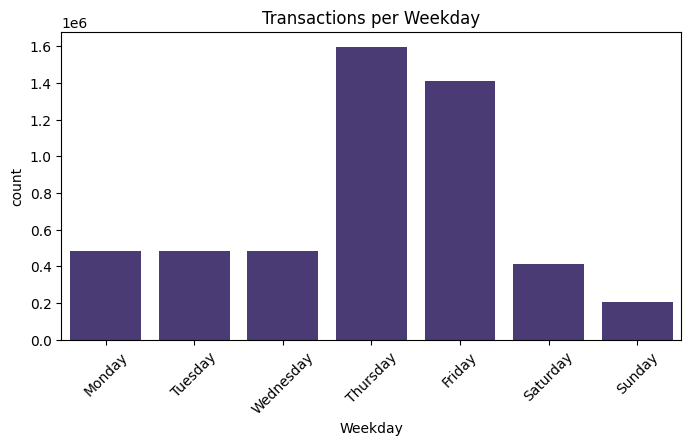

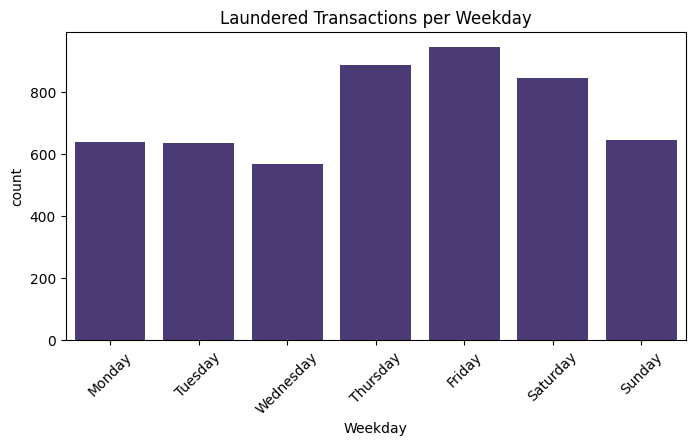

In [29]:
# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Weekday'] = df['Timestamp'].dt.day_name()

# Count of transactions per weekday
weekday_counts = df['Weekday'].value_counts()
print("\nTransaction Count per Weekday:")
print(weekday_counts)

# Count plot for each weekday
plt.figure(figsize=(8, 4))
sns.countplot(x=df['Weekday'], order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("Transactions per Weekday")
plt.xticks(rotation=45)
plt.show()

######################

laundered_df = df[df['Is Laundering'] == 1]
# Count of transactions per weekday
weekday_counts = laundered_df['Weekday'].value_counts()


# Count plot for each weekday
plt.figure(figsize=(8, 4))
sns.countplot(x=laundered_df['Weekday'], order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("Laundered Transactions per Weekday")
plt.xticks(rotation=45)
plt.show()

In [24]:
# Create a contingency table
contingency_table = pd.crosstab(df['Weekday'], df['Is Laundering'])

# Perform Chi-Square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-Square Test Statistic: {chi2:.4f}")
print(f"P-value: {p:.4f}")

if p < 0.05:
    print("There is a significant relationship between Weekday and Is Laundering.")
else:
    print("No significant relationship found between Weekday and Is Laundering.")

Chi-Square Test Statistic: 1921.4076
P-value: 0.0000
There is a significant relationship between Weekday and Is Laundering.


### From Bank & To Bank

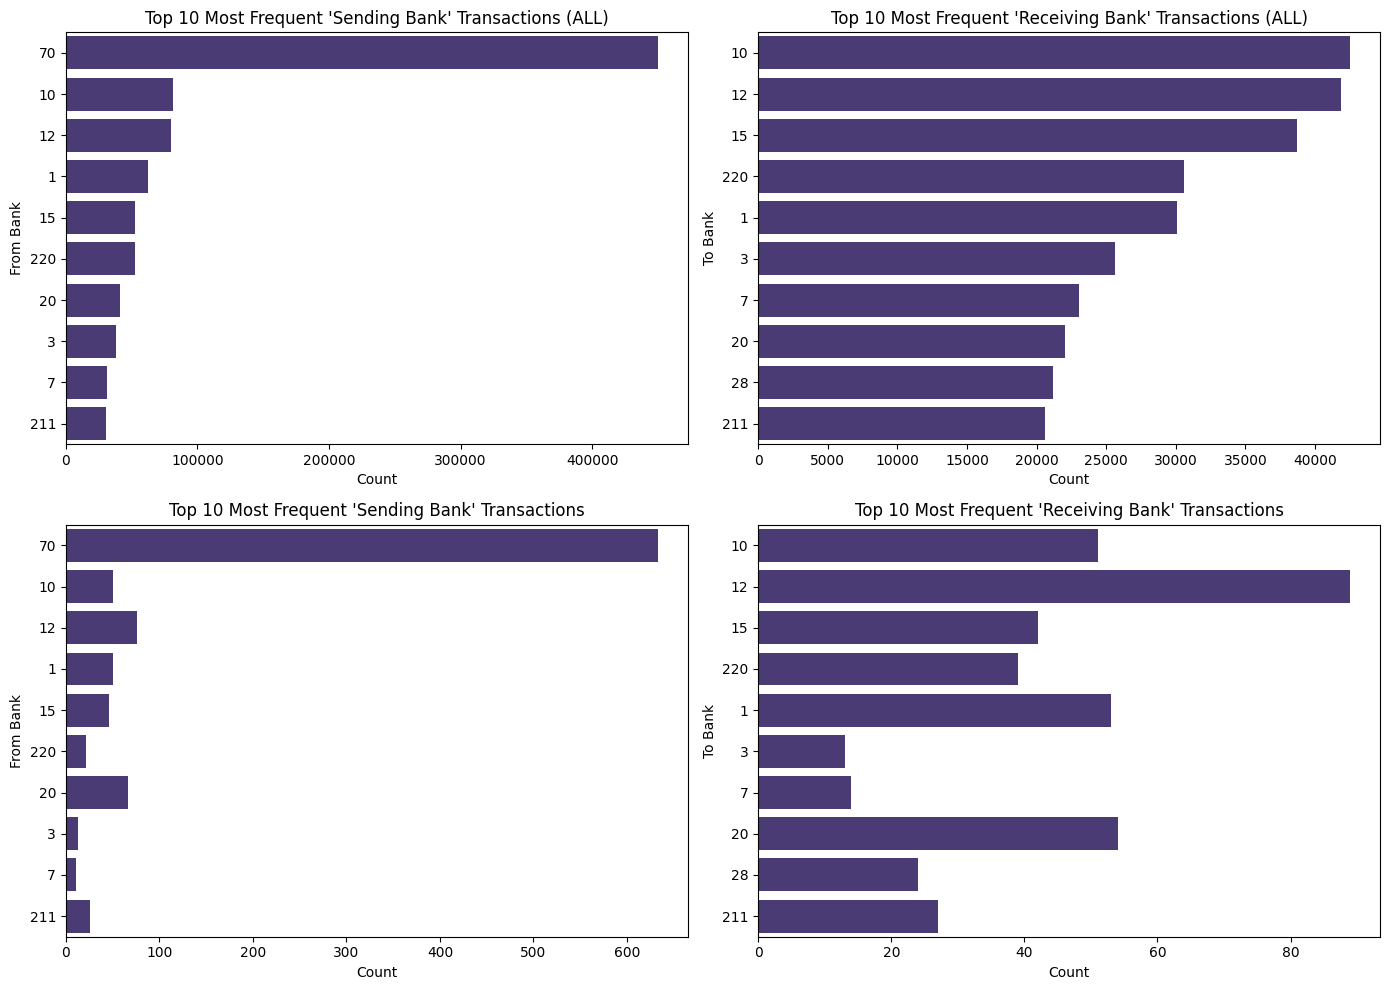

In [31]:
df['From Bank'] = df['From Bank'].astype('category')
df['To Bank'] = df['To Bank'].astype('category')

# Limit to top 20 most frequent banks for better readability
top_n = 10
top_sender_banks = df['From Bank'].value_counts().nlargest(top_n).index
top_receiver_banks = df['To Bank'].value_counts().nlargest(top_n).index

# Set up the subplots: 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# First plot - From Bank (df)
sns.countplot(y=df[df['From Bank'].isin(top_sender_banks)]['From Bank'], 
              order=top_sender_banks, ax=axs[0, 0])
axs[0, 0].set_title(f"Top {top_n} Most Frequent 'Sending Bank' Transactions (ALL)")
axs[0, 0].set_xlabel("Count")
axs[0, 0].set_ylabel("From Bank")

# Second plot - To Bank (df)
sns.countplot(y=df[df['To Bank'].isin(top_receiver_banks)]['To Bank'], 
              order=top_receiver_banks, ax=axs[0, 1])
axs[0, 1].set_title(f"Top {top_n} Most Frequent 'Receiving Bank' Transactions (ALL)")
axs[0, 1].set_xlabel("Count")
axs[0, 1].set_ylabel("To Bank")

# Third plot - From Bank (laundered_df)
sns.countplot(y=laundered_df[laundered_df['From Bank'].isin(top_sender_banks)]['From Bank'], 
              order=top_sender_banks, ax=axs[1, 0])
axs[1, 0].set_title(f"Top {top_n} Most Frequent 'Sending Bank' Transactions")
axs[1, 0].set_xlabel("Count")
axs[1, 0].set_ylabel("From Bank")

# Fourth plot - To Bank (laundered_df)
sns.countplot(y=laundered_df[laundered_df['To Bank'].isin(top_receiver_banks)]['To Bank'], 
              order=top_receiver_banks, ax=axs[1, 1])
axs[1, 1].set_title(f"Top {top_n} Most Frequent 'Receiving Bank' Transactions")
axs[1, 1].set_xlabel("Count")
axs[1, 1].set_ylabel("To Bank")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [15]:
# Chi-Square test for 'From Bank'
contingency_from_bank = pd.crosstab(df['From Bank'], df['Is Laundering'])
chi2_from, p_from, _, _ = stats.chi2_contingency(contingency_from_bank)

print(f"Chi-Square Test for From Bank:\nChi-Square Statistic: {chi2_from:.4f}, P-value: {p_from:.4f}")
if p_from < 0.05:
    print("Significant relationship found between From Bank and Is Laundering.")
else:
    print("No significant relationship found between From Bank and Is Laundering.")

# Chi-Square test for 'To Bank'
contingency_to_bank = pd.crosstab(df['To Bank'], df['Is Laundering'])
chi2_to, p_to, _, _ = stats.chi2_contingency(contingency_to_bank)

print(f"\nChi-Square Test for To Bank:\nChi-Square Statistic: {chi2_to:.4f}, P-value: {p_to:.4f}")
if p_to < 0.05:
    print("Significant relationship found between To Bank and Is Laundering.")
else:
    print("No significant relationship found between To Bank and Is Laundering.")


Chi-Square Test for From Bank:
Chi-Square Statistic: 17376.1925, P-value: 1.0000
No significant relationship found between From Bank and Is Laundering.

Chi-Square Test for To Bank:
Chi-Square Statistic: 6623.2778, P-value: 1.0000
No significant relationship found between To Bank and Is Laundering.


### Currency

/var/folders/4z/4lgchhkd1154cdlhyxr67nn80000gn/T/ipykernel_64636/3429673762.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['Receiving Currency'], order=df['Receiving Currency'].value_counts().index, palette='viridis')


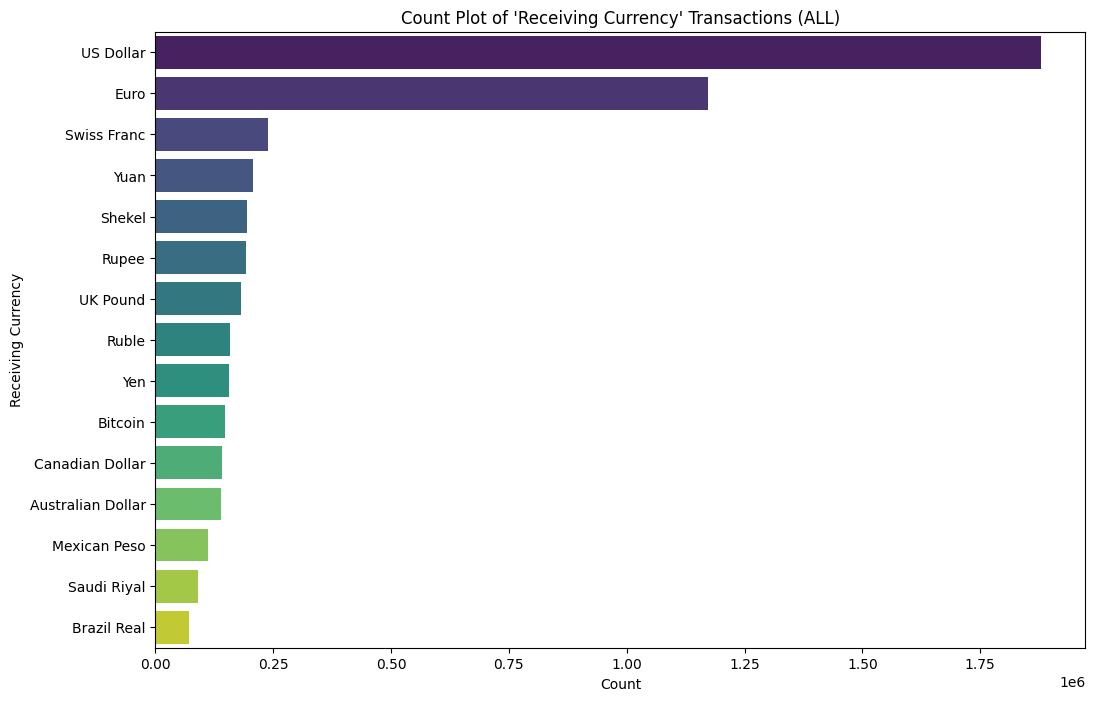

/var/folders/4z/4lgchhkd1154cdlhyxr67nn80000gn/T/ipykernel_64636/3429673762.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Receiving Currency'] = df1['Receiving Currency'].astype('category')
/var/folders/4z/4lgchhkd1154cdlhyxr67nn80000gn/T/ipykernel_64636/3429673762.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df1['Receiving Currency'], order=df1['Receiving Currency'].value_counts().index, palette='viridis')


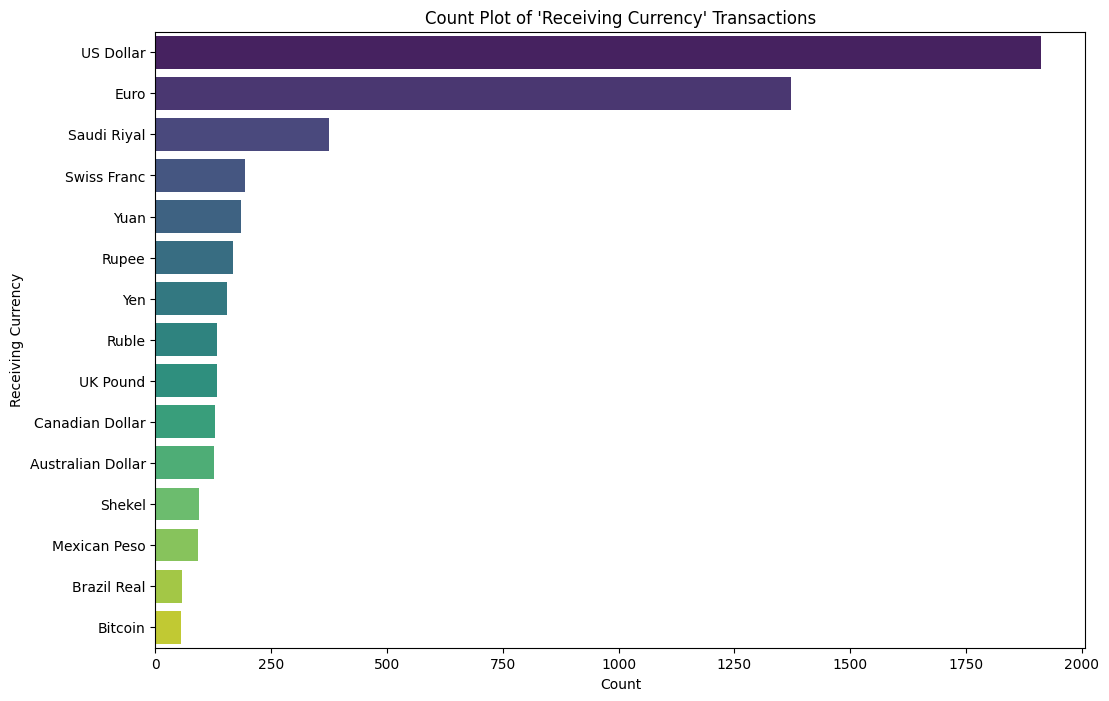

In [18]:
df['Receiving Currency'] = df['Receiving Currency'].astype('category')

# Count plot for 'Receiving Currency' ranked by counts
plt.figure(figsize=(12, 8))
sns.countplot(y=df['Receiving Currency'], order=df['Receiving Currency'].value_counts().index, palette='viridis')

plt.title("Count Plot of 'Receiving Currency' Transactions (ALL)")
plt.xlabel("Count")
plt.ylabel("Receiving Currency")
plt.show()

#-----------------------------------
df1['Receiving Currency'] = df1['Receiving Currency'].astype('category')

# Count plot for 'Receiving Currency' ranked by counts
plt.figure(figsize=(12, 8))
sns.countplot(y=df1['Receiving Currency'], order=df1['Receiving Currency'].value_counts().index, palette='viridis')

plt.title("Count Plot of 'Receiving Currency' Transactions")
plt.xlabel("Count")
plt.ylabel("Receiving Currency")
plt.show()

In [20]:
# Chi-Square test for 'Receiving Currency'
contingency_receiving = pd.crosstab(df['Receiving Currency'], df['Is Laundering'])
chi2_receiving, p_receiving, _, _ = stats.chi2_contingency(contingency_receiving)

print(f"Chi-Square Test for Receiving Currency:\nChi-Square Statistic: {chi2_receiving:.4f}, P-value: {p_receiving:.4f}")
if p_receiving < 0.05:
    print("Significant relationship found between Receiving Currency and Is Laundering.")
else:
    print("No significant relationship found between Receiving Currency and Is Laundering.")

# Chi-Square test for 'Payment Currency'
contingency_payment = pd.crosstab(df['Payment Currency'], df['Is Laundering'])
chi2_payment, p_payment, _, _ = stats.chi2_contingency(contingency_payment)

print(f"\nChi-Square Test for Payment Currency:\nChi-Square Statistic: {chi2_payment:.4f}, P-value: {p_payment:.4f}")
if p_payment < 0.05:
    print("Significant relationship found between Payment Currency and Is Laundering.")
else:
    print("No significant relationship found between Payment Currency and Is Laundering.")


Chi-Square Test for Receiving Currency:
Chi-Square Statistic: 1058.3514, P-value: 0.0000
Significant relationship found between Receiving Currency and Is Laundering.

Chi-Square Test for Payment Currency:
Chi-Square Statistic: 1069.2973, P-value: 0.0000
Significant relationship found between Payment Currency and Is Laundering.


In [23]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

# Step 1: Prepare data
df = df.dropna(subset=['Receiving Currency', 'Is Laundering'])  # Drop missing values
df['Receiving Currency'] = df['Receiving Currency'].astype('category').cat.codes  # Convert to numeric

# Select covariates (potential confounders)
covariates = ['Amount Received', 'Amount Paid', 'To Bank', 'From Bank']
X = df[covariates]
y = df['Receiving Currency']  # Treatment variable

# Step 2: Estimate propensity scores
propensity_model = LogisticRegression()
propensity_model.fit(X, y)
df['Propensity Score'] = propensity_model.predict_proba(X)[:, 1]

# Step 3: Match treated and control units
treated = df[df['Receiving Currency'] == 1]
control = df[df['Receiving Currency'] == 0]

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['Propensity Score']])
distances, indices = nn.kneighbors(treated[['Propensity Score']])

matched_control = control.iloc[indices.flatten()]
matched_df = pd.concat([treated, matched_control])

# Step 4: Estimate causal effect
causal_model = sm.Logit(matched_df['Is Laundering'], sm.add_constant(matched_df['Receiving Currency'])).fit()
print(causal_model.summary())

/Users/zoujingyi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Optimization terminated successfully.
         Current function value: 0.002895
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:          Is Laundering   No. Observations:               296284
Model:                          Logit   Df Residuals:                   296282
Method:                           MLE   Df Model:                            1
Date:                Tue, 11 Feb 2025   Pseudo R-squ.:                0.001780
Time:                        20:41:22   Log-Likelihood:                -857.75
converged:                       True   LL-Null:                       -859.28
Covariance Type:            nonrobust   LLR p-value:                   0.08026
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -8.2421      0.160    -51.465      0.000      -8.556      -7.928
Rece

* p-value = 0.083:
Since p > 0.05, we fail to reject the null hypothesis, meaning there is no strong evidence that receiving currency influences money laundering.

### Payment Format

/var/folders/4z/4lgchhkd1154cdlhyxr67nn80000gn/T/ipykernel_64636/4272733419.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['Payment Format'], order=df['Payment Format'].value_counts().index, palette='viridis')


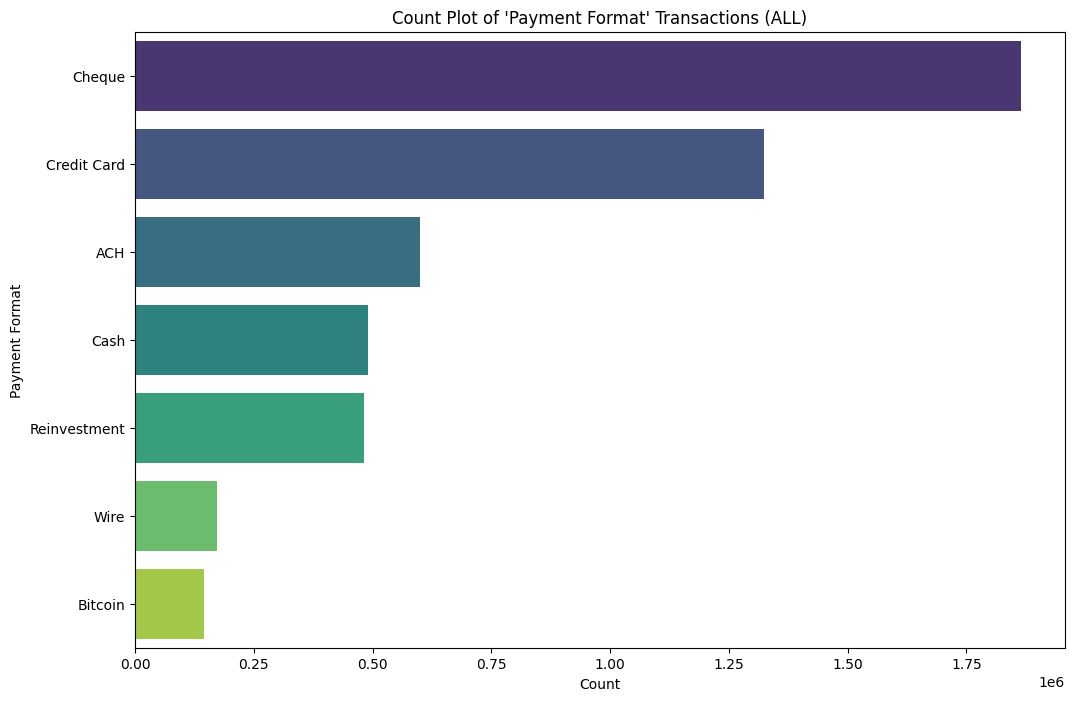

/var/folders/4z/4lgchhkd1154cdlhyxr67nn80000gn/T/ipykernel_64636/4272733419.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df1['Payment Format'], order=df1['Payment Format'].value_counts().index, palette='viridis')


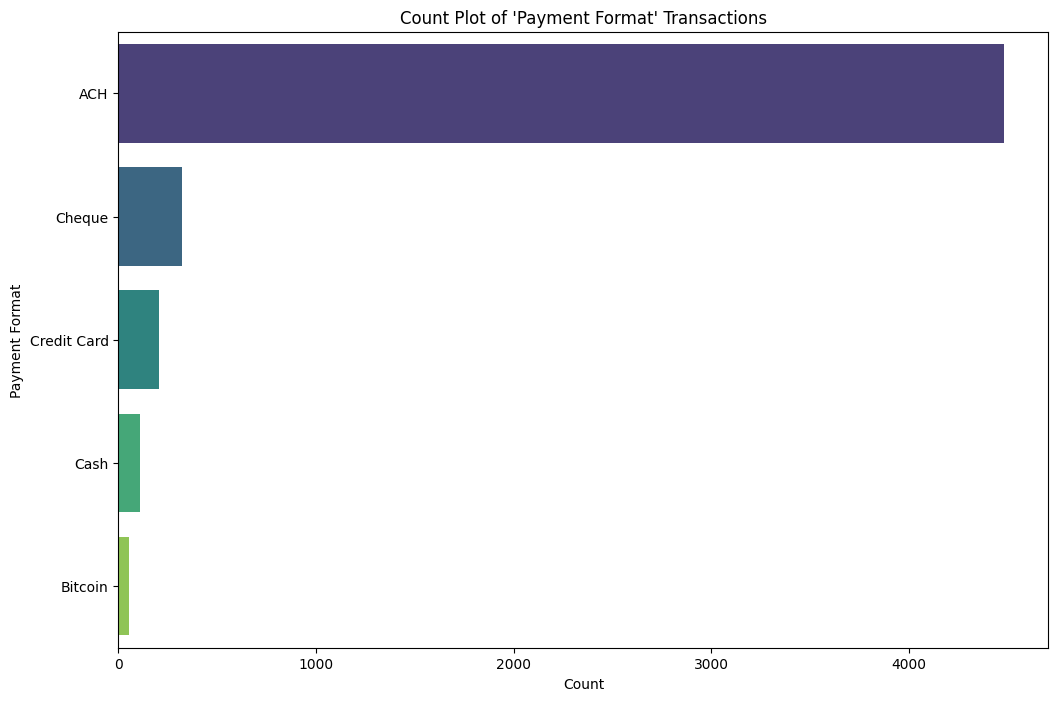

In [25]:
df['Payment Format'] = df['Payment Format'].astype('category')
# Count plot for 'Payment Format' ranked by counts
plt.figure(figsize=(12, 8))
sns.countplot(y=df['Payment Format'], order=df['Payment Format'].value_counts().index, palette='viridis')

plt.title("Count Plot of 'Payment Format' Transactions (ALL)")
plt.xlabel("Count")
plt.ylabel("Payment Format")
plt.show()

#------------------------------------
df1['Payment Format'] = df1['Payment Format'].astype('category')
# Count plot for 'Payment Format' ranked by counts
plt.figure(figsize=(12, 8))
sns.countplot(y=df1['Payment Format'], order=df1['Payment Format'].value_counts().index, palette='viridis')

plt.title("Count Plot of 'Payment Format' Transactions")
plt.xlabel("Count")
plt.ylabel("Payment Format")
plt.show()

In [27]:
# Chi-Square test for 'Payment Currency'
contingency_payment = pd.crosstab(df['Payment Currency'], df['Is Laundering'])
chi2_payment, p_payment, _, _ = stats.chi2_contingency(contingency_payment)

print(f"Chi-Square Test for Payment Currency:")
print(f"Chi-Square Statistic: {chi2_payment:.4f}")
print(f"P-value: {p_payment:.4f}")

if p_payment < 0.05:
    print("Significant relationship found between Payment Currency and Is Laundering.")
else:
    print("No significant relationship found between Payment Currency and Is Laundering.")

Chi-Square Test for Payment Currency:
Chi-Square Statistic: 1069.2973
P-value: 0.0000
Significant relationship found between Payment Currency and Is Laundering.


### Amount

/var/folders/4z/4lgchhkd1154cdlhyxr67nn80000gn/T/ipykernel_64636/1197618731.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['Amount Received Category'], order=df['Amount Received Category'].value_counts().index, palette='viridis')


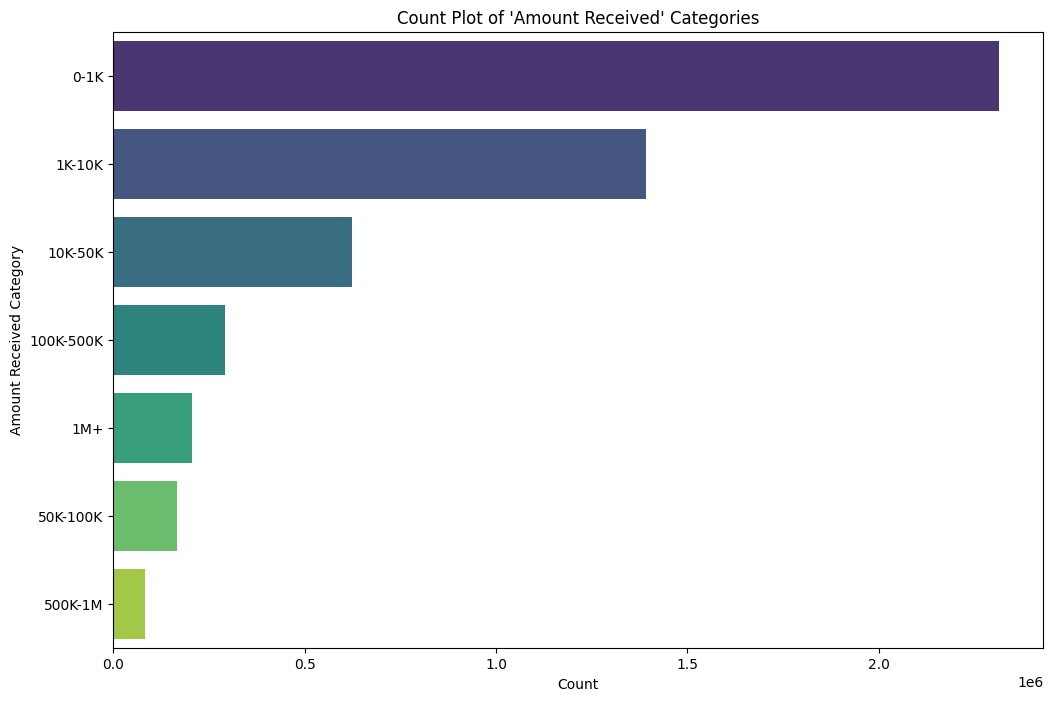

/var/folders/4z/4lgchhkd1154cdlhyxr67nn80000gn/T/ipykernel_64636/1197618731.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df1['Amount Received Category'], order=df1['Amount Received Category'].value_counts().index, palette='viridis')


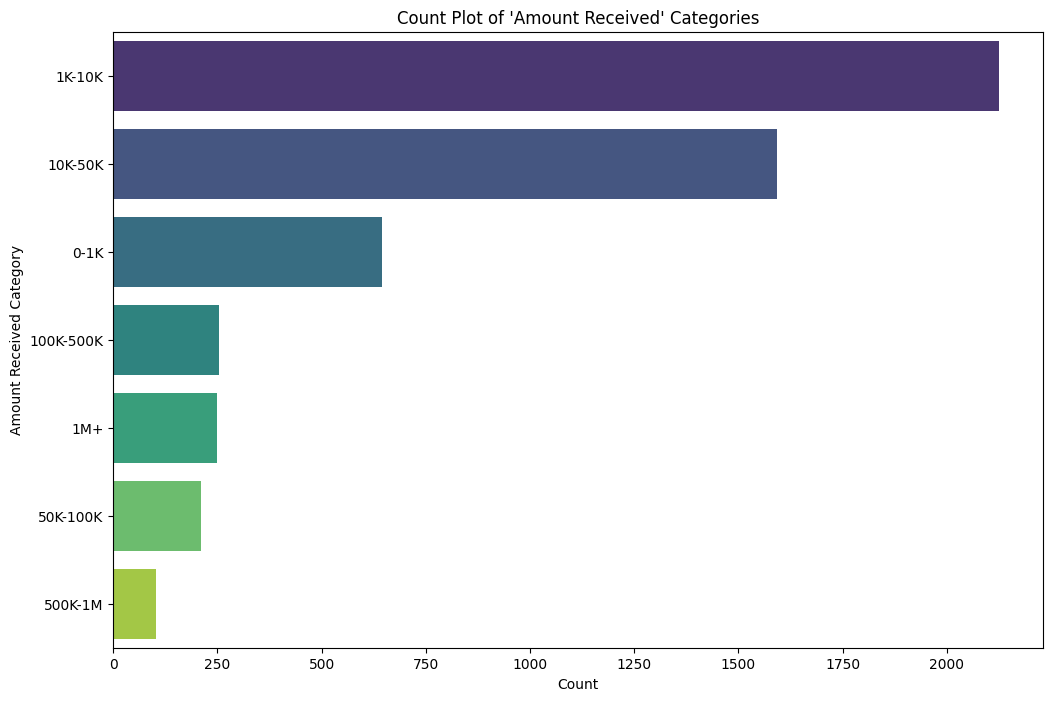

In [28]:
# Binning 'Amount Received' into categories
bins = [0, 1000, 10000, 50000, 100000, 500000, 1000000, df['Amount Received'].max()]
bin_labels = ['0-1K', '1K-10K', '10K-50K', '50K-100K', '100K-500K', '500K-1M', '1M+']
df['Amount Received Category'] = pd.cut(df['Amount Received'], bins=bins, labels=bin_labels)
# Count plot for 'Amount Received' categories
plt.figure(figsize=(12, 8))
sns.countplot(y=df['Amount Received Category'], order=df['Amount Received Category'].value_counts().index, palette='viridis')

plt.title("Count Plot of 'Amount Received' Categories")
plt.xlabel("Count")
plt.ylabel("Amount Received Category")
plt.show()

#-------------------------------------------------------

# Binning 'Amount Received' into categories
bins = [0, 1000, 10000, 50000, 100000, 500000, 1000000, df1['Amount Received'].max()]
bin_labels = ['0-1K', '1K-10K', '10K-50K', '50K-100K', '100K-500K', '500K-1M', '1M+']
df1['Amount Received Category'] = pd.cut(df1['Amount Received'], bins=bins, labels=bin_labels)
# Count plot for 'Amount Received' categories
plt.figure(figsize=(12, 8))
sns.countplot(y=df1['Amount Received Category'], order=df1['Amount Received Category'].value_counts().index, palette='viridis')

plt.title("Count Plot of 'Amount Received' Categories")
plt.xlabel("Count")
plt.ylabel("Amount Received Category")
plt.show()


In [ ]:
# Chi-Square test for 'Amount Received'
contingency_amount = pd.crosstab(pd.cut(df['Amount Received'], bins=5), df['Is Laundering'])
chi2_amount, p_amount, _, _ = stats.chi2_contingency(contingency_amount)

print(f"Chi-Square Test for Amount Received:")
print(f"Chi-Square Statistic: {chi2_amount:.4f}")
print(f"P-value: {p_amount:.4f}")

if p_amount < 0.05:
    print("Significant relationship found between Amount Received and Is Laundering.")
else:
    print("No significant relationship found between Amount Received and Is Laundering.")

# Propensity Score Matching (PSM) for Amount Received
# Drop missing values and encode categorical variables
df = df.dropna(subset=['Amount Received', 'Is Laundering'])

# Select covariates (potential confounders)
covariates = ['To Bank', 'From Bank', 'Payment Currency', 'Receiving Currency']
df = pd.get_dummies(df, columns=covariates, drop_first=True)
X = df.drop(columns=['Is Laundering'])
y = df['Is Laundering']

# Estimate propensity scores
propensity_model = LogisticRegression()
propensity_model.fit(X, y)
df['Propensity Score'] = propensity_model.predict_proba(X)[:, 1]

# Match treated and control units
treated = df[df['Is Laundering'] == 1]
control = df[df['Is Laundering'] == 0]

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['Propensity Score']])
distances, indices = nn.kneighbors(treated[['Propensity Score']])

matched_control = control.iloc[indices.flatten()]
matched_df = pd.concat([treated, matched_control])

# Estimate causal effect using logistic regression
causal_model = sm.Logit(matched_df['Is Laundering'], sm.add_constant(matched_df['Amount Received'])).fit()
print(causal_model.summary())


Chi-Square Test for Amount Received:
Chi-Square Statistic: 0.0122
P-value: 0.9996
No significant relationship found between Amount Received and Is Laundering.


## Graph Construction

In [ ]:
# Extract unique account numbers as nodes
accounts = pd.concat([df['From Account'], df['To Account']]).unique()
nodes_df = pd.DataFrame({'Account': accounts})

# Save nodes to CSV
nodes_df.to_csv('./data/nodes.csv', index=False)

In [ ]:
# Create edge set
edges_df = df[['From Account', 'To Account', 'Timestamp', 'Amount Received']].copy()
edges_df.columns = ['Source', 'Target', 'Interval', 'Weight']
edges_df['Type'] = 'Directed'

# Convert Timestamp to interval (assuming intervals are relative to the first transaction)
edges_df['Interval'] = (pd.to_datetime(edges_df['Interval']) - pd.to_datetime(edges_df['Interval']).min()).dt.total_seconds() / 60

# Save edges to CSV
edges_df.to_csv('./data/edges.csv', index=False)

In [36]:
# Load nodes and edges
df_nodes = pd.read_csv('./data/nodes.csv')
df_edges = pd.read_csv('./data/edges.csv')

In [37]:
# Create graph
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(df_nodes['From Account'])

# Add edges
edges = [(row['Source'], row['Target'], row['Weight']) for _, row in df_edges.iterrows()]
G.add_weighted_edges_from(edges)

# Extract connected components
components = list(nx.weakly_connected_components(G))
selected_components = components[:1]  # Select only two connected components

# Create subgraph with selected components
subgraph_nodes = set().union(*selected_components)
G_sub = G.subgraph(subgraph_nodes)

# Plot the network graph with selected components
fig, ax = plt.subplots(figsize=(12, 8))
pos = nx.spring_layout(G_sub, seed=42)
nx.draw(G_sub, pos, with_labels=True, node_size=500, node_color='lightblue', edge_color='gray', alpha=0.6, font_size=8, ax=ax)
edge_labels = {(row['Source'], row['Target']): f"{row['Weight']}" for _, row in df_edges.iterrows() if row['Source'] in subgraph_nodes and row['Target'] in subgraph_nodes}
nx.draw_networkx_edge_labels(G_sub, pos,font_size=6, ax=ax)

plt.title("Transaction Network Graph - One Connected Components")
plt.show()


KeyboardInterrupt: 

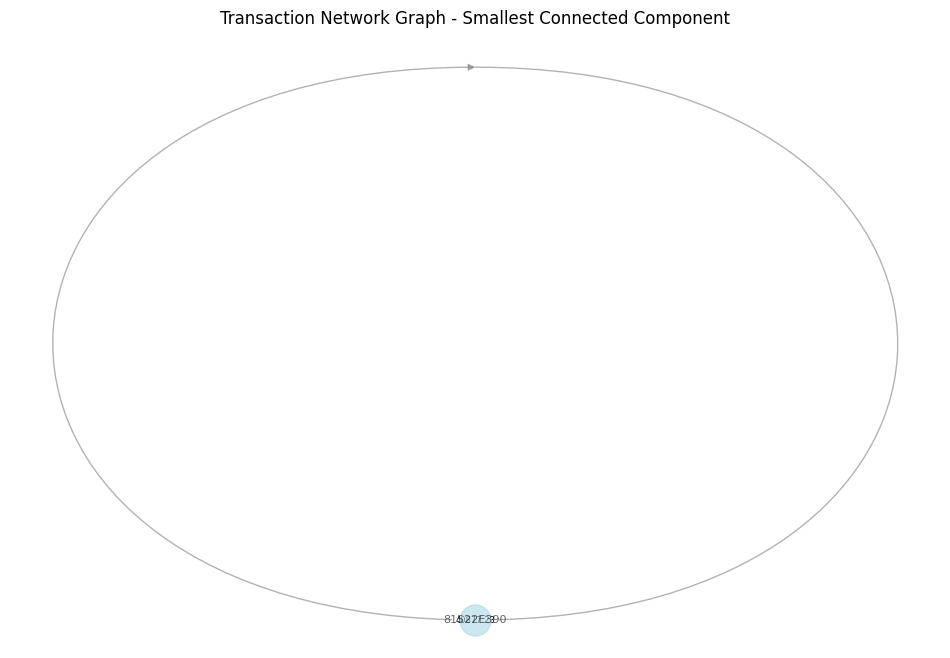

In [46]:
# Create graph
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(df_nodes['From Account'])

# Add edges
edges = [(row['Source'], row['Target'], row['Weight']) for _, row in df_edges.iterrows()]
G.add_weighted_edges_from(edges)

# Extract connected components and choose the smallest one
components = list(nx.weakly_connected_components(G))
smallest_component = min(components, key=len)

# Create subgraph with the smallest connected component
G_sub = G.subgraph(smallest_component)

# Plot the network graph with the smallest connected component
fig, ax = plt.subplots(figsize=(12, 8))
pos = nx.spring_layout(G_sub, seed=42)
nx.draw(G_sub, pos, with_labels=True, node_size=500, node_color='lightblue', edge_color='gray', alpha=0.6, font_size=8, ax=ax)
edge_labels = {(row['Source'], row['Target']): f"{row['Weight']}" for _, row in df_edges.iterrows() if row['Source'] in smallest_component and row['Target'] in smallest_component}
nx.draw_networkx_edge_labels(G_sub, pos, edge_labels=edge_labels, font_size=6, ax=ax)

plt.title("Transaction Network Graph - Smallest Connected Component")
plt.show()

Number of rows in df_nodes: 5304
Number of rows in df_edges: 3565


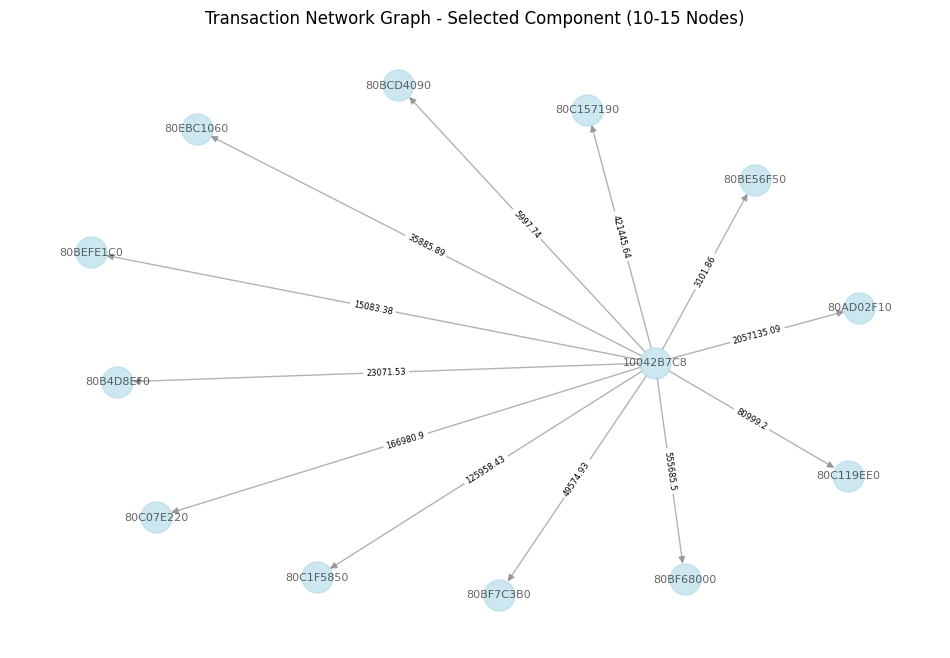

In [48]:
# Print number of rows
print(f"Number of rows in df_nodes: {len(df_nodes)}")
print(f"Number of rows in df_edges: {len(df_edges)}")

# Create graph
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(df_nodes['Account'])

# Add edges
edges = [(row['Source'], row['Target'], row['Weight']) for _, row in df_edges.iterrows()]
G.add_weighted_edges_from(edges)

# Extract connected components and find one with 10-15 nodes
components = list(nx.weakly_connected_components(G))
selected_component = next((comp for comp in components if 10 <= len(comp) <= 15), None)

if selected_component:
    # Create subgraph with selected component
    G_sub = G.subgraph(selected_component)

    # Plot the network graph with selected component
    fig, ax = plt.subplots(figsize=(12, 8))
    pos = nx.spring_layout(G_sub, seed=42)
    nx.draw(G_sub, pos, with_labels=True, node_size=500, node_color='lightblue', edge_color='gray', alpha=0.6, font_size=8, ax=ax)
    edge_labels = {(row['Source'], row['Target']): f"{row['Weight']}" for _, row in df_edges.iterrows() if row['Source'] in selected_component and row['Target'] in selected_component}
    nx.draw_networkx_edge_labels(G_sub, pos, edge_labels=edge_labels, font_size=6, ax=ax)

    plt.title("Transaction Network Graph - Selected Component (10-15 Nodes)")
    plt.show()
else:
    print("No connected component with 10-15 nodes found.")


In [ ]:
 # Compute network statistics
avg_degree_centrality = sum(nx.degree_centrality(G).values())
avg_weighted_degree_centrality = sum(nx.in_degree_centrality(G).values())
num_connected_components = nx.number_weakly_connected_components(G)

print(f"Average Degree Centrality (Unweighted): {avg_degree_centrality}")
print(f"Average Degree Centrality (Weighted): {avg_weighted_degree_centrality}")
print(f"Number of Connected Components: {num_connected_components}")

## Modeling

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

In [3]:
df = pd.read_csv('./data/HI-Small_Trans.csv')

In [4]:
currency_conversion_rates = {
    'US Dollar': 1.0,
    'Euro': 1.03, 
    'Swiss Franc': 1.09, 
    'Yuan': 0.14, 
    'Shekel': 0.28,
    'Rupee': 0.012, 
    'UK Pound': 1.24, 
    'Yen': 0.0066, 
    'Ruble': 0.01, 
    'Bitcoin': 95781.21,
    'Canadian Dollar': 0.7, 
    'Australian Dollar': 0.63, 
    'Mexican Peso': 0.049, 
    'Saudi Riyal': 0.27, 
    'Brazil Real': 0.17
}

df['Amount Paid (USD)'] = df.apply(lambda row: row['Amount Paid'] * currency_conversion_rates.get(row['Payment Currency'], 1), axis=1)
df['Amount Received (USD)'] = df.apply(lambda row: row['Amount Received'] * currency_conversion_rates.get(row['Receiving Currency'], 1), axis=1)

In [5]:

df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['year'] = df['Timestamp'].dt.year  
df['month'] = df['Timestamp'].dt.month  
df['day'] = df['Timestamp'].dt.day  
df['hour'] = df['Timestamp'].dt.hour
df['second'] = df['Timestamp'].dt.second 

df.drop(columns=['Timestamp','Amount Paid','Amount Received' ], inplace=True)

cat_col = ['From Bank', 'Account', 'To Bank', 'Account.1', 'Receiving Currency', 'Payment Currency', 'Payment Format']
for col in cat_col:
    df[col] = LabelEncoder().fit_transform(df[col])

In [7]:
G = nx.DiGraph()

for _, row in df.iterrows():
    G.add_edge(row['Account'], row['Account.1'], weight=row['Amount Paid (USD)'])

df['degree_centrality'] = df['Account'].map(nx.degree_centrality(G))
df['pagerank'] = df['Account'].map(nx.pagerank(G))

In [8]:
df.head()

,From Bank,Account,To Bank,Account.1,Receiving Currency,Payment Currency,Payment Format,Is Laundering,Amount Paid (USD),Amount Received (USD),year,month,day,hour,second,degree_centrality,pagerank
0,8,942,8,900,12,12,5,0,3697.34,3697.34,2022,9,1,0,0,0.000012,1.373167e-06
1,109,990,0,949,12,12,3,0,0.01,0.01,2022,9,1,0,0,0.000008,3.783561e-07
2,110,991,106,940,12,12,5,0,14675.57,14675.57,2022,9,1,0,0,0.000004,2.091255e-06
3,10,997,10,945,12,12,5,0,2806.97,2806.97,2022,9,1,0,0,0.000008,3.542830e-06
4,8,999,8,947,12,12,5,0,36682.97,36682.97,2022,9,1,0,0,0.000016,7.287749e-07


In [9]:
# Convert numerical features into tensors
feature_cols = ["Amount Paid (USD)", "Amount Received (USD)", "year", "month", "day", "hour", "second",
                "degree_centrality", "pagerank"]

node_features = torch.tensor(df[feature_cols].values, dtype=torch.float)

# Convert labels to tensor (1 = Money laundering, 0 = Legitimate)
labels = torch.tensor(df["Is Laundering"].values, dtype=torch.long)

# Create edge index for PyTorch Geometric (source → destination)
edge_index = torch.tensor(df[["Account", "Account.1"]].values.T, dtype=torch.long)

# Create PyG Data object
data = Data(x=node_features, edge_index=edge_index, y=labels)

# Print PyG data structure
print(data)

Data(x=[5078345, 9], edge_index=[2, 5078345], y=[5078345])


In [10]:
import torch.nn.functional as F
import torch.nn as nn

# Define the GNN model
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Instantiate the model
model = GNN(input_dim=node_features.shape[1], hidden_dim=16, output_dim=2)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()


In [11]:
# Move data to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Loss: {loss.item():.4f}")


Epoch 0 - Loss: 105568.8047
Epoch 10 - Loss: 2181.0286
Epoch 20 - Loss: 3105.4849
Epoch 30 - Loss: 3291.8318
Epoch 40 - Loss: 3176.6948
Epoch 50 - Loss: 2932.5525
Epoch 60 - Loss: 2633.6089
Epoch 70 - Loss: 2312.6775
Epoch 80 - Loss: 1984.7249
Epoch 90 - Loss: 1656.8198


In [12]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Get predicted labels
    accuracy = (pred == data.y).sum().item() / len(data.y)

print(f"Final Model Accuracy: {accuracy:.4f}")


Final Model Accuracy: 0.9990
